# Convolutional neural networks (CNNs)

## Definitie si Operatia de Convolutie

Operatia de convolutie in cazul 2D discret:

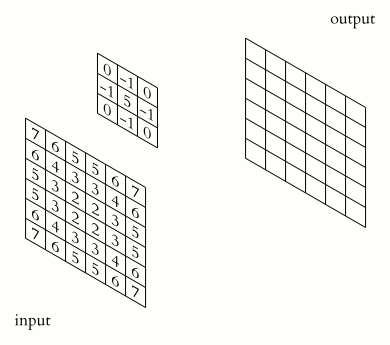

Image source: https://en.wikipedia.org/wiki/Convolution#/media/File:2D_Convolution_Animation.gif


<img src="https://drive.google.com/uc?export=view&id=1Q2uoqTn8FZZWWy4W5r2PuCfPpWtVM7Ts">

## Ce este stratul convolutional?

In [ ]:
nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

Tensorul asociat stratului convolutional anterior:

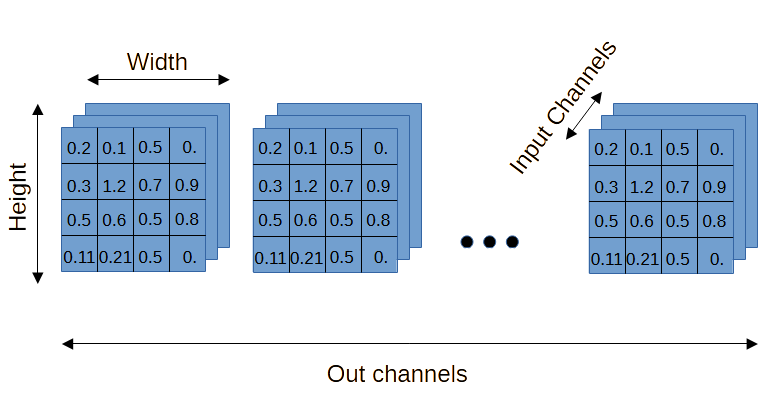

### Proprietatile stratului convolutional

1. **Parameter Sharing**

Intr-o retea fully connected (MLP) un parametrul al acesteia este folosit o singura data in procesarea unui exemplu, pe cand in CNN un parametru ( o pozitie dintr-un filtru) este folosit pentru fiecare pozitie a tensorului de intrare (daca stride-ul este 1).

2. **Local Connectivity**

In CNNs o valoare din mapa de activare rezulta din aplicarea filtrului pe o zona locala, pe cand in MLP fiecare neuron este conectat cu intreg semnalul de intrare.

3. **Equivariance to Translation**

Un filtru va produce acelasi nivel de activare pentru un pattern in semnal, indiferent de locul unde pattern-ul respectiv se afla.

### Ce este stratul de pooling?

In [ ]:
nn.MaxPool2d(kernel_size, stride)

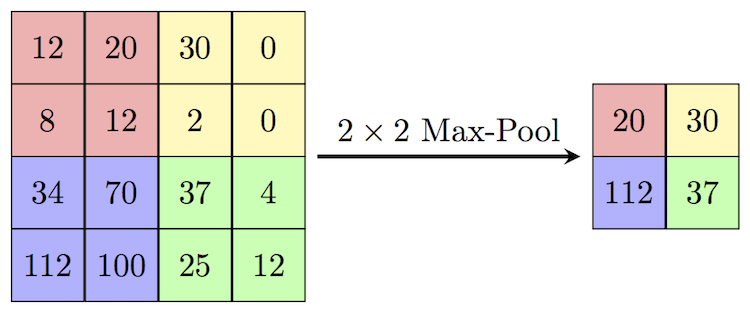
Image source: https://paperswithcode.com/method/max-pooling

## Structura unei retele convolutionale
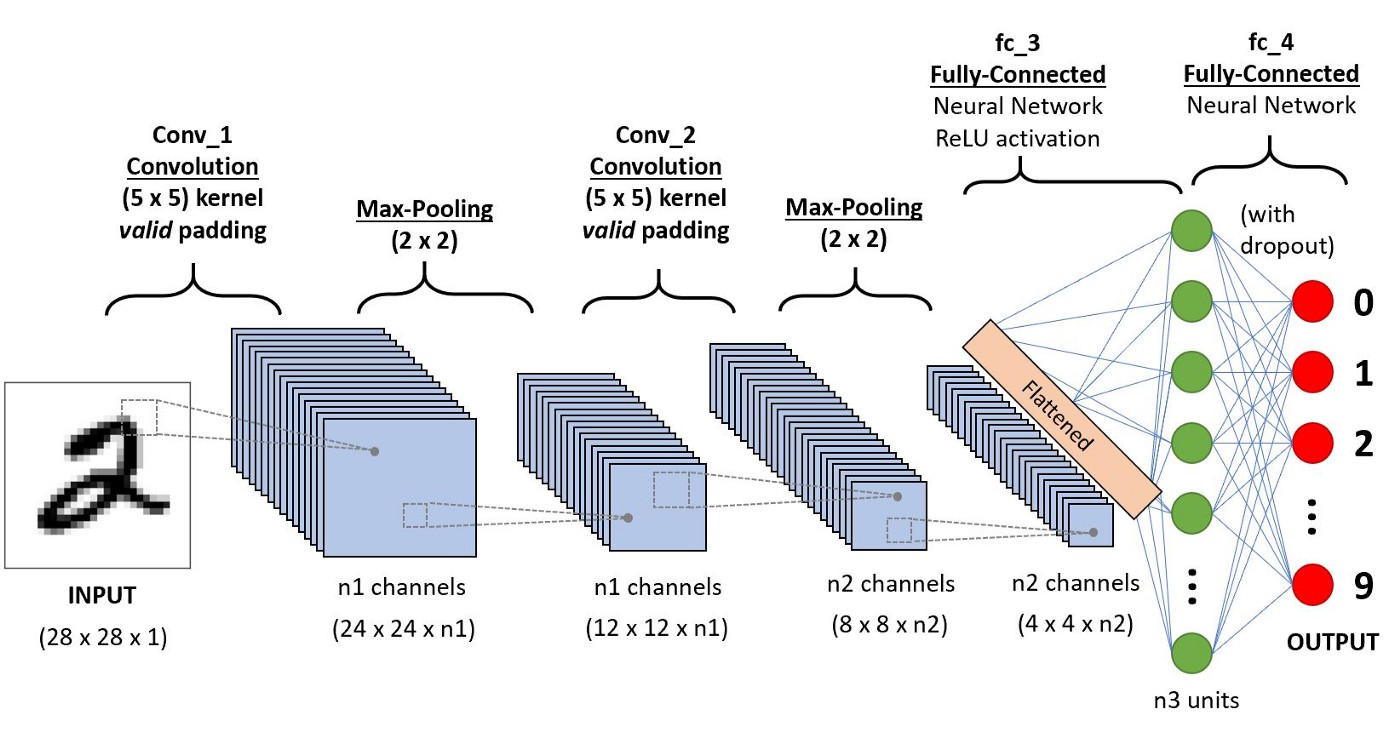

Image source: https://paperswithcode.com/methods/category/convolutional-neural-networks

In imaginea de mai sus se foloseste **Flatten** pentru a transforma tensorul din forma 3D intr-unul 1 dimensional. O alta varianta este sa aplicam pooling + squeeze pe dimensiunile spatiale. In Pytorch putem implementa asta cu **nn.AdaptiveMaxPool2d**:
https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html#torch.nn.AdaptiveMaxPool2d


**Exemplu:**

In [1]:
import torch
import torch.nn as nn
pooling = nn.AdaptiveMaxPool2d((1, 1))
result = pooling(torch.rand(5, 64, 4, 4))
print(f"Shape dupa operatia de pooling:{result.shape}")
print(f"Shape dupa squeeze:{torch.squeeze(result).shape}")

Shape dupa operatia de pooling:torch.Size([5, 64, 1, 1])
Shape dupa squeeze:torch.Size([5, 64])


# Exercitii

### 1. Creati reteaua din imaginea de mai sus, dar cu dimensiunea filtrelor (kernel size) setata la 3.  Antrenati si testati performanta retelei pe setul de date **CIFAR10**.

a) folositi $n1=32$, $n2=64$ si $n3=128$ si adaugati activarea ReLU dupa straturile convolutionale.

b) folositi $n1=64$, $n2=128$ si $n3=256$ si adaugati activarea ReLU dupa straturile convolutionale.

c) aceeasi configuratie ca la punctul b), dar setati kernel size la 5 pentru primul strat.

```
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())
```

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define your transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    ),
])

# Define the trainset and testset
train_dataset = datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the trainloader and the testloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

class ConvNet(nn.Module):
    def __init__(self, n1=16, n2=32, n3=120):
        super(ConvNet, self).__init__()
        #
        # Conv1: input = 3 channels, output = n1 channels,  kernel_size=3, no padding
        #    Input spatial size: 32 × 32
        #    After conv:       (32 - 3 + 1) × (32 - 3 + 1) = 30 × 30  ⇒ 30×30×n1
        #    After 2×2 maxpool: 30//2 × 30//2 = 15 × 15        ⇒ 15×15×n1
        #
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n1, kernel_size=3, padding=0)
        
        #
        # Conv2: input = n1 channels, output = n2 channels, kernel_size=3, no padding
        #    Input spatial size: 15 × 15
        #    After conv:        (15 - 3 + 1) × (15 - 3 + 1) = 13 × 13   ⇒ 13×13×n2
        #    After 2×2 maxpool: 13//2 × 13//2 = 6 × 6               ⇒ 6×6×n2
        #
        self.conv2 = nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=3, padding=0)

        #
        # At this point, after the two conv+pool stages, each sample’s feature‐map tensor is
        #   size: (n2 channels) × (6 height) × (6 width) = n2 * 6 * 6 features.
        # We’ll flatten that and feed into a fully connected layer of size n3, then into 10 output logits.
        #
        self.fc3 = nn.Linear(in_features=n2 * 6 * 6, out_features=n3)
        self.fc4 = nn.Linear(in_features=n3, out_features=10)

    def forward(self, x):
        # x: (batch_size, 3, 32, 32)
        x = F.relu(self.conv1(x))       # → (batch, n1, 30, 30)
        x = F.max_pool2d(x, kernel_size=2)  # → (batch, n1, 15, 15)

        x = F.relu(self.conv2(x))       # → (batch, n2, 13, 13)
        x = F.max_pool2d(x, kernel_size=2)  # → (batch, n2, 6, 6)

        x = x.view(x.size(0), -1)       # flatten: (batch, n2*6*6)
        x = F.relu(self.fc3(x))         # → (batch, n3)
        x = self.fc4(x)                 # → (batch, 10)  (logits for 10 classes)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvNet(n1=32, n2=64, n3=128).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)                  # forward pass
        loss = loss_function(outputs, labels)        # cross‐entropy loss
        loss.backward()                          # backward pass
        optimizer.step()                         # update weights

        running_loss += loss.item()
        if (batch_idx + 1) % 200 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], "
                  f"Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {running_loss / 200:.4f}")
            running_loss = 0.0

    # --- End of one epoch; evaluate on test set ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)                   # (batch, 10)
            _, predicted = torch.max(outputs.data, 1) # predicted shape: (batch,)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"*** Epoch [{epoch}/{num_epochs}] Test Accuracy: {accuracy:.2f}% ***\n")


### 2. Introduceti straturi BatchNorm2D in reteaua de la exercitiul precedent. Testati din nou performanta pe setul de date CIFAR10. Ce observati?
Documentatie: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define your transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    ),
])

# Define the trainset and testset
train_dataset = datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the trainloader and the testloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

class ConvNet(nn.Module):
    def __init__(self, n1=16, n2=32, n3=120):
        super(ConvNet, self).__init__()
        #
        # Conv1: input = 3 channels, output = n1 channels,  kernel_size=3, no padding
        #    Input spatial size: 32 × 32
        #    After conv:       (32 - 3 + 1) × (32 - 3 + 1) = 30 × 30  ⇒ 30×30×n1
        #    After 2×2 maxpool: 30//2 × 30//2 = 15 × 15        ⇒ 15×15×n1
        #
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n1, kernel_size=3, padding=0)
        self.normalize1 = nn.BatchNorm2d(n1)
        
        #
        # Conv2: input = n1 channels, output = n2 channels, kernel_size=3, no padding
        #    Input spatial size: 15 × 15
        #    After conv:        (15 - 3 + 1) × (15 - 3 + 1) = 13 × 13   ⇒ 13×13×n2
        #    After 2×2 maxpool: 13//2 × 13//2 = 6 × 6               ⇒ 6×6×n2
        #
        self.conv2 = nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=3, padding=0)
        self.normalize2 = nn.BatchNorm2d(n2)

        #
        # At this point, after the two conv+pool stages, each sample’s feature‐map tensor is
        #   size: (n2 channels) × (6 height) × (6 width) = n2 * 6 * 6 features.
        # We’ll flatten that and feed into a fully connected layer of size n3, then into 10 output logits.
        #
        self.fc3 = nn.Linear(in_features=n2 * 6 * 6, out_features=n3)
        self.fc4 = nn.Linear(in_features=n3, out_features=10)

    def forward(self, x):
        # x: (batch_size, 3, 32, 32)
        x = F.relu(self.normalize1(self.conv1(x)))       # → (batch, n1, 30, 30)
        x = F.max_pool2d(x, kernel_size=2)  # → (batch, n1, 15, 15)

        x = F.relu(self.normalize2(self.conv2(x)))       # → (batch, n2, 13, 13)
        x = F.max_pool2d(x, kernel_size=2)  # → (batch, n2, 6, 6)

        x = x.view(x.size(0), -1)       # flatten: (batch, n2*6*6)
        x = F.relu(self.fc3(x))         # → (batch, n3)
        x = self.fc4(x)                 # → (batch, 10)  (logits for 10 classes)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvNet(n1=64, n2=128, n3=256).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)                  # forward pass
        loss = loss_function(outputs, labels)        # cross‐entropy loss
        loss.backward()                          # backward pass
        optimizer.step()                         # update weights

        running_loss += loss.item()
        if (batch_idx + 1) % 200 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], "
                  f"Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {running_loss / 200:.4f}")
            running_loss = 0.0

    # --- End of one epoch; evaluate on test set ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)                   # (batch, 10)
            _, predicted = torch.max(outputs.data, 1) # predicted shape: (batch,)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"*** Epoch [{epoch}/{num_epochs}] Test Accuracy: {accuracy:.2f}% ***\n")


### 3. Inlocuiti **Flatten** in reteaua de la exercitiul anterior cu max pooling ca in exemplul de mai sus.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from numpy import squeeze

# Define your transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    ),
])

# Define the trainset and testset
train_dataset = datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the trainloader and the testloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

class ConvNet(nn.Module):
    def __init__(self, n1=16, n2=32, n3=120):
        super(ConvNet, self).__init__()
        #
        # Conv1: input = 3 channels, output = n1 channels,  kernel_size=3, no padding
        #    Input spatial size: 32 × 32
        #    After conv:       (32 - 3 + 1) × (32 - 3 + 1) = 30 × 30  ⇒ 30×30×n1
        #    After 2×2 maxpool: 30//2 × 30//2 = 15 × 15        ⇒ 15×15×n1
        #
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n1, kernel_size=3, padding=0)
        self.normalize1 = nn.BatchNorm2d(n1)
        
        #
        # Conv2: input = n1 channels, output = n2 channels, kernel_size=3, no padding
        #    Input spatial size: 15 × 15
        #    After conv:        (15 - 3 + 1) × (15 - 3 + 1) = 13 × 13   ⇒ 13×13×n2
        #    After 2×2 maxpool: 13//2 × 13//2 = 6 × 6               ⇒ 6×6×n2
        #
        self.conv2 = nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=3, padding=0)
        self.normalize2 = nn.BatchNorm2d(n2)

        #
        # At this point, after the two conv+pool stages, each sample’s feature‐map tensor is
        #   size: (n2 channels) × (6 height) × (6 width) = n2 * 6 * 6 features.
        # After adaptive max pooling: n2 * 1 * 1 features.
        # Feed into a fully connected layer of size n3, then into 10 output logits.
        #
        self.fc3 = nn.Linear(in_features=n2, out_features=n3)
        self.fc4 = nn.Linear(in_features=n3, out_features=10)

    def forward(self, x):
        # x: (batch_size, 3, 32, 32)
        x = F.relu(self.normalize1(self.conv1(x)))       # → (batch, n1, 30, 30)
        x = F.max_pool2d(x, kernel_size=2)  # → (batch, n1, 15, 15)

        x = F.relu(self.normalize2(self.conv2(x)))       # → (batch, n2, 13, 13)
        x = F.max_pool2d(x, kernel_size=2)  # → (batch, n2, 6, 6)

        x = F.adaptive_max_pool2d(x, (1, 1))     # flatten: (batch, n2, 1, 1)
        x = squeeze(x)
        x = F.relu(self.fc3(x))         # → (batch, n3)
        x = self.fc4(x)                 # → (batch, 10)  (logits for 10 classes)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvNet(n1=64, n2=128, n3=256).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)                  # forward pass
        loss = loss_function(outputs, labels)        # cross‐entropy loss
        loss.backward()                          # backward pass
        optimizer.step()                         # update weights

        running_loss += loss.item()
        if (batch_idx + 1) % 200 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], "
                  f"Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {running_loss / 200:.4f}")
            running_loss = 0.0

    # --- End of one epoch; evaluate on test set ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)                   # (batch, 10)
            _, predicted = torch.max(outputs.data, 1) # predicted shape: (batch,)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"*** Epoch [{epoch}/{num_epochs}] Test Accuracy: {accuracy:.2f}% ***\n")

model.parameters()

### 4. In acest exercitiu vom implementa **ResNet-18**.

a) Creati o clasa care sa implementeze stack-ul de straturi descris in imaginea urmatoare. Numarul de canale in imagine este 64, in implementarea voastra faceti-l configurabil. Observati operatia de adunare efectuata intre tensorul de intrare si iesire din bloc (poarta numele de skip/residual connection).

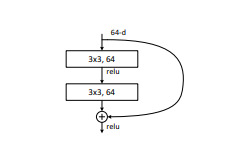

b) Folosindu-va de bloc-ul de straturi implementat la punctul anterior, implementati arhitectura din imaginea urmatoare. In cazul nostru imaginile nu sunt de rezolutie (100, 100), de aceea setam kernel size in primul strat la 3, in loc de 7 cum este in imagine.


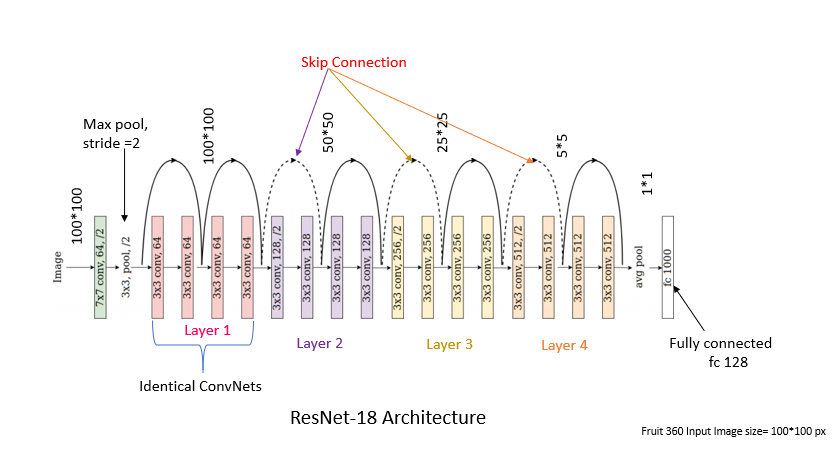!



In [ ]:
# Homework...

### 5. Implementati propria functie echivalenta cu cross entropia.

```def cross_entropy(prediction, target)```



In [ ]:
# Homework...

### 6. Modificati reteaua de la exercitiul 2 astfel incat sa renuntati la straturile fully connected de la final si sa le inlocuiti cu straturi de pooling si straturi convolutionale.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define your transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    ),
])

# Define the trainset and testset
train_dataset = datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the trainloader and the testloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

class ConvNetFCN(nn.Module):
    def __init__(self, n1=16, n2=32, n3=120):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n1, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(n1)

        self.conv2 = nn.Conv2d(n1, n2, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(n2)

        # New conv layers replacing FC layers
        self.conv3 = nn.Conv2d(n2, n3, kernel_size=1)  # acts like fc3
        self.conv4 = nn.Conv2d(n3, 10, kernel_size=1)  # acts like fc4

        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # to reduce to (1, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # (N, n1, 15, 15)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # (N, n2, 6, 6)

        x = F.relu(self.conv3(x))                       # (N, n3, 6, 6)
        x = self.conv4(x)                               # (N, 10, 6, 6)
        x = self.global_pool(x)                         # (N, 10, 1, 1)
        x = x.view(x.size(0), -1)                       # (N, 10) – final logits
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvNetFCN(n1=64, n2=128, n3=256).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)                  # forward pass
        loss = loss_function(outputs, labels)        # cross‐entropy loss
        loss.backward()                          # backward pass
        optimizer.step()                         # update weights

        running_loss += loss.item()
        if (batch_idx + 1) % 200 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], "
                  f"Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {running_loss / 200:.4f}")
            running_loss = 0.0

    # --- End of one epoch; evaluate on test set ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)                   # (batch, 10)
            _, predicted = torch.max(outputs.data, 1) # predicted shape: (batch,)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"*** Epoch [{epoch}/{num_epochs}] Test Accuracy: {accuracy:.2f}% ***\n")


### 7. Creati o vizualizare pentru filtrele din primul si ultimul strat convolutional (pentru primele 8 canale).

Hint: Folositi metoda parameters() a modelului pentru a accesa straturile.

In [ ]:
# Homework...